# Описание проекта

Целью проекта является выбрать из предложенных гипотез по увеличению выручки интернет магазину наиболее подходящую для проверки путем A/B-теста, и проанализировать результаты этого теста.  

В ходе работы мы:  
1. Приоритизируем гипотезы по двум медотам и выберем наиболее подходящую для проверки;  
1. Сравним исследуемые группы по ряду критериев:  
> - куммулятивные выручка, средний чек, конверсия;  
> - количество заказов на пользователя, средняя стоимость заказа.  
1. Проверим, являются ли различия между группами статистически значимыми.  

По итогам работы сделаем вывод касательно теста &#8212; остановить его, признав победу одной из групп или отсутствие между ними разницы, или продолжить тестирование. 

## Описание данных

**Файл с гипотезами `hypothesis.csv`**:  


`Hypothesis` — краткое описание гипотезы;  
`Reach` — охват пользователей по 10-балльной шкале;  
`Impact` — влияние на пользователей по 10-балльной шкале;  
`Confidence` — уверенность в гипотезе по 10-балльной шкале;  
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

**Файлы с результатами теста**

Заказы `orders.csv`

`transactionId` — идентификатор заказа;  
`visitorId` — идентификатор пользователя, совершившего заказ;  
`date` — дата, когда был совершён заказ;  
`revenue` — выручка заказа;  
`group` — группа A/B-теста, в которую попал заказ.

Посетители `visitors.csv`

`date` — дата;  
`group` — группа A/B-теста;  
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

# Приоритизация гипотез

Ознакомимся с данными, приоритизируем гипотезы по двум методам: ICE и RICE. 

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
pd.options.display.max_colwidth = 1
plt.style.use('seaborn-darkgrid')

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


У нас есть список гипотез, оценка их параметров. Исходя из этих данных мы сможем приоритизировать гипотезы и выбрать ту, которую стоит протестировать в первую очередь. 

Для дальнейшего удобства названия столбцов приведем к нижнему регистру. 

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

## Оценка гипотез по ICE

Добавим сболбец с коэффициентом каждой гипотезы по методу ICE. Для этого произведение `impact` и `confidence` разделим на `efforts`.

In [5]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']

In [6]:
hypothesis.sort_values('ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


По этой методике лидером является гипотеза 8, вслед за ней 0 и 7. Однако в расчетах не учтено количество людей, которых затронет изменение, параметр `reach`.  

Добавим также расчеты с учетом этого параметра, посмотрим, какие будут результаты. 

## Оценка гипотез по RICE

In [7]:
hypothesis['rice'] = (
    (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
)

In [8]:
hypothesis.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Учет количества людей, на которых скажется изменение, очень сильно меняет картину.  

8-я гипотеза скатывается с первого место в середину списка, лидером с преимуществом в 2 раза является гипетеза номер 7. Она охватывает максимальное количество клиентов, имеет одни из наиболее сильных уровней влияния и уверенности. 

Так как второй метод описывает эффект от внедрения новой опции более полно, при выборе гипотезы для проверки будем полагаться на него.  

Соответственно, запускаем A/B-тест для проверки гипотезы #7. 

# Анализ результатов A/B-теста

## Предобработка данных

По результатам теста у нас есть два файла с данными: данные о посещениях и о заказах. 

Для начала ознакомимся с ними и приведем к удобному для дальнейшей работы виду. 

In [9]:
visitors = pd.read_csv('visitors.csv')

In [10]:
orders = pd.read_csv('orders.csv')

In [11]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В таблице `orders` названия некоторых столбцов не соответствуют стилю, поэтому переименуем их. 

In [13]:
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

### Проверка на пропуски и дубликаты

In [14]:
visitors.duplicated().sum()

0

In [15]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [16]:
orders.duplicated().sum()

0

In [17]:
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

Данные чистые от пропусков и дубликатов.   


### Проверка на соответствие типов данных

In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [19]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Видим, что в обеих таблицах дата представлена в виде строки. Переведем ее в более подходящий тип данных. 

In [20]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
    )

In [21]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
    )

### Проверка на пересечение пользователей в группах

Прежде чем приступить к дальнейшему анализу проверим также, не попали ли пользователи в две группы одновременно. 

Для этого выделим пары с `visitor_id` и `group` в отдельную таблицу и проверим ее на дубликаты. 

In [22]:
orders['visitor_id'].nunique()

1031

In [23]:
users_group_a = orders[orders['group']=='A'][['visitor_id', 'group']].drop_duplicates()

In [24]:
users_group_b = orders[orders['group']=='B'][['visitor_id', 'group']].drop_duplicates()

In [25]:
users_group = (
pd.concat(
[users_group_a['visitor_id'],
users_group_b['visitor_id']],
    axis=0
)
)

In [26]:
users_group.duplicated().sum()

58

In [27]:
'{:.3f}'.format(users_group.duplicated().sum()/orders['visitor_id'].nunique())

'0.056'

В нашей выборке есть дубликаты. Значит, несколько клиентов попали в обе группы.  
Таких клиентов около 6% от всех. Определить их к какой-то конкретной мы не сможем, поэтому просто удалим этих клиентов из наших данных, и продолжим проверку без них. 

In [28]:
# список id дубликатов

users_group = users_group[users_group.duplicated()]

In [29]:
orders = orders[np.logical_not(orders['visitor_id'].isin(users_group))]

In [30]:
orders['visitor_id'].nunique()

973

Теперь, когда мы знаем, что в данных нет пропусков, дубликатов, типы данных проставлены корректно, можно двигаться дальше. 

## Анализ результатов

Основная цель исследования &#8212; найти функцию, которая поможет увеличить выручку.  

Соответственно, первым делом проверим, как распределяется выручка по группам теста. 

### График куммулятивной выручки

Для этого посчитаем кумулятивные значения выручки и построим их график.  

Будем строить граифк именно по кумулятивным показателям, так как в этом случае мы сможем увидеть более стабильные показатели. График не будет иметь больших колебаний, как в случае с анализом ежедневной выручки. 

In [31]:
# для начала соберем данные по активности пользователей по группам

# соберем датасет, в котором будут уникальные пары "дата - группа" за время
# проведения теста

dates_groups = orders[['date', 'group']].drop_duplicates()

In [32]:
# соберем кумулятивные данные по выручке, количеству заказов, посетителей. 

# агрегированные данные по выручке
orders_agregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                     orders['group'] == x['group'])]
                                      .agg({'date':'max', 
                                            'group':'max', 
                                            'transaction_id':'nunique', 
                                            'visitor_id':'nunique',
                                            'revenue':'sum'}),
                                      axis=1).sort_values(by=['date', 'group'])                                      


In [33]:
# агрегированные данные по посетителям
visitors_agregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                     visitors['group'] == x['group'])]
                                      .agg({'date':'max', 
                                            'group':'max', 
                                            'visitors':'sum'}),
                                      axis=1).sort_values(by=['date', 'group'])

In [34]:
# сводим данные в одну таблицу
cummulative_data = (
    orders_agregated.merge(visitors_agregated, 
                           left_on = ['date', 'group'], 
                           right_on = ['date', 'group'])
    )

In [35]:
cummulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [36]:
cummulative_data.head()


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [37]:
cummulative_data[cummulative_data['group']=='A']['visitors'].max()

18736

In [38]:
cummulative_data[cummulative_data['group']=='B']['visitors'].max()

18916

Собрали накопительные данные по группам. Удостоверились, что выборка пользователей практически идентичная по размеру.  

Теперь по собранным данным построим график.

Из собранного датасета выделим данные по группам в отдельности. 

In [39]:
cummulative_revenue_a = cummulative_data[cummulative_data['group']=='A'][['date', 'revenue', 'orders']]
cummulative_revenue_b = cummulative_data[cummulative_data['group']=='B'][['date', 'revenue', 'orders']]

In [40]:
cummulative_revenue_a.head()

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


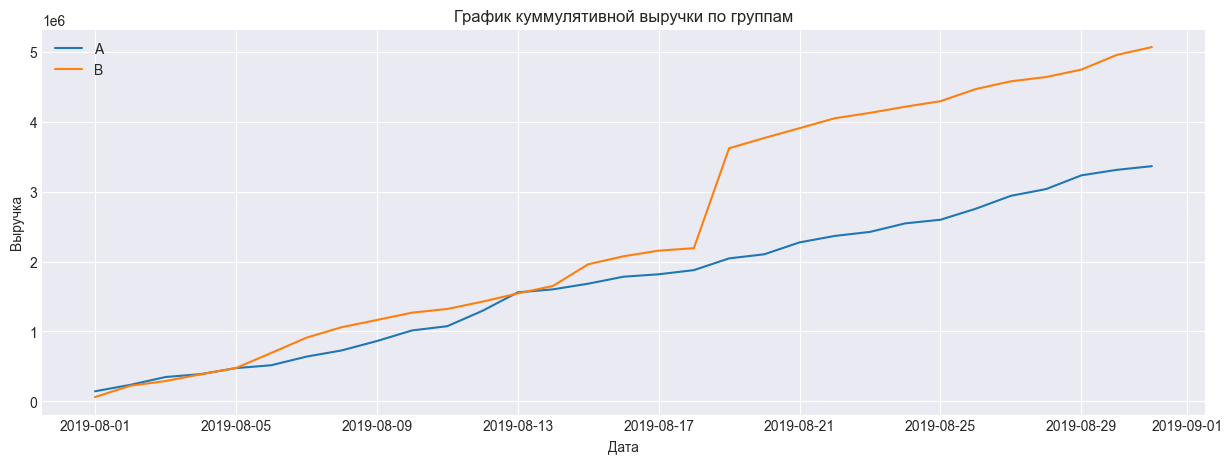

In [41]:
# визуализируем данные

plt.figure(figsize=(15,5))
plt.plot(cummulative_revenue_a['date'], cummulative_revenue_a['revenue'], label='A')
plt.plot(cummulative_revenue_b['date'], cummulative_revenue_b['revenue'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График куммулятивной выручки по группам');

По графику видим, что выручка группы Б была на протяжении теста немного выше группы А, и в какой-то момент произошел резкий скачок, после которого разница стала еще больше.  
Вероятно, был нехарактерно крупный заказ, или внезапно увеличилось их количество в течение дня.  

Нужно будет проверить сопутствующие характеристики, такие как:  
> средний чек;  
> среднее количество заказов.  

Также необходимо будет проверить влияние аномалий на результат. 

### График куммулятивного среднего чека

Посмотрим, как выглядят графики куммулятивного среднего чека для наших групп.  

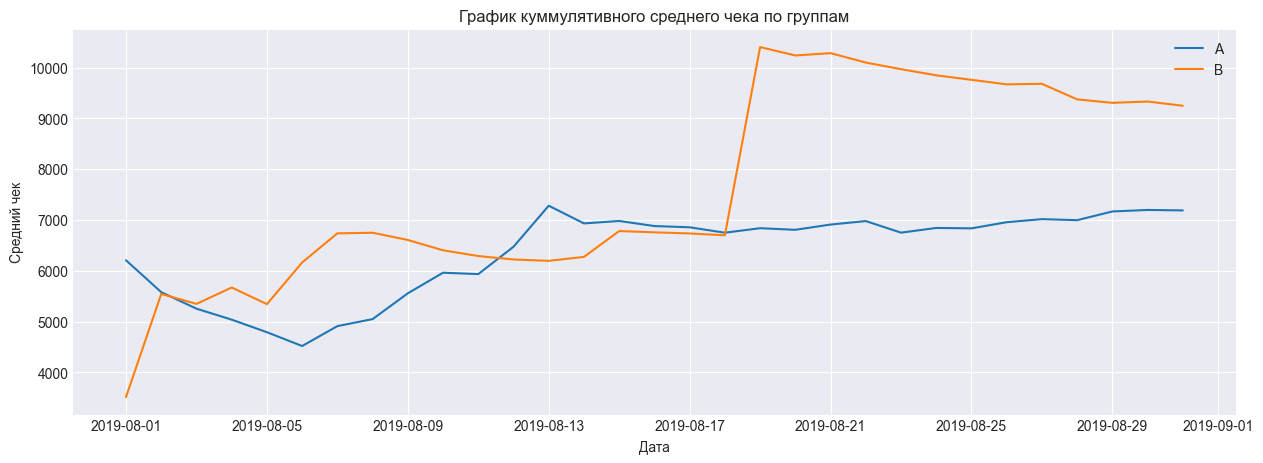

In [42]:
plt.figure(figsize=(15,5))
plt.plot(cummulative_revenue_a['date'], 
         cummulative_revenue_a['revenue']/cummulative_revenue_a['orders'], 
         label='A')
plt.plot(cummulative_revenue_b['date'], 
         cummulative_revenue_b['revenue']/cummulative_revenue_b['orders'], 
         label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('График куммулятивного среднего чека по группам');

По этому графику видим, что средний чек колеблется, в основном он был выше по группе Б, и также как по выручке, видим скачок в увеличении среднего чека по группе Б, после чего идет его снижение. Очень похоже на разовую крупную покупку. 

Также построим график относительного изменения куммулятивного среднего чека группы Б к группе А. 

Для этого нам нужно объединить датасеты  `cummulative_revenue` в один. 

In [43]:
cummulative_revenue_merged = cummulative_revenue_a.merge(cummulative_revenue_b,  
                                                         left_on='date', 
                                                         right_on = 'date', 
                                                         how = 'left',
                                                         suffixes = ['A', 'B'])

In [44]:
cummulative_revenue_merged.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


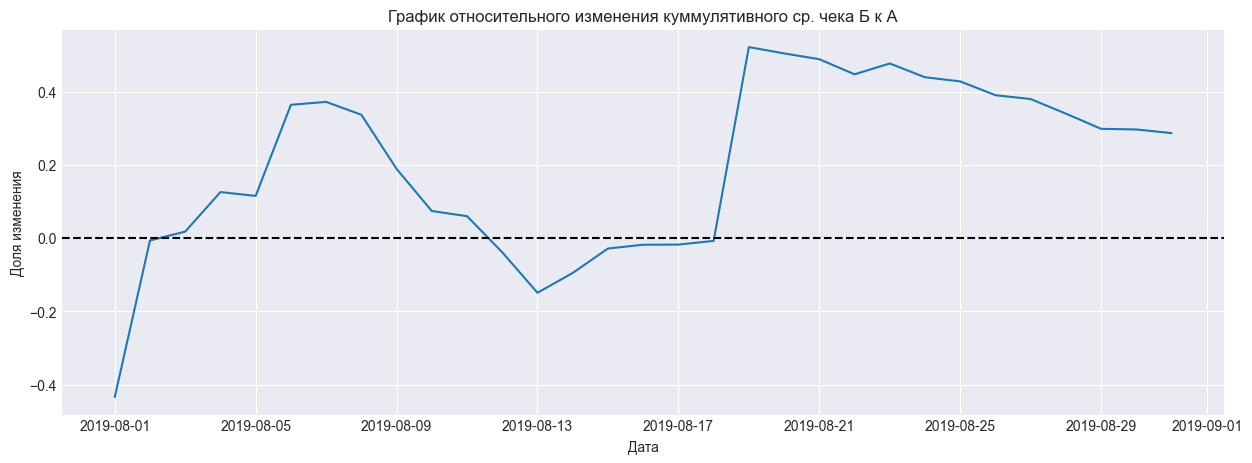

In [45]:
# строим график относительного изменения 

plt.figure(figsize=(15,5))
plt.plot(cummulative_revenue_merged['date'], 
        ( cummulative_revenue_merged['revenueB']/cummulative_revenue_merged['ordersB'])/
        (cummulative_revenue_merged['revenueA']/cummulative_revenue_merged['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Доля изменения')
plt.title('График относительного изменения куммулятивного ср. чека Б к А');

Мы видим, что в начале эксперименти группа Б проигрывала группе А. После этого она вырвалась вперед, но спустя некоторое время опять пошла по нисходящей.  
Далее снова был плавный рост, после чего резкое увеличение отрыва (подозреваемая аномалия). Также мы видим тенденцию к выравниванию разницы после этого выброса, так как график идет по нисходящей. 

В целом, большая часть графика находится выше нуля, то есть в основном средний чек группы Б выше, чем у группы А. Но мы не можем пока сказать это наверняка, не проверив информацию на очищенных от выбросов данных. 

### График куммулятивной конверсии

Сравним, как соотносятся конверсии по группам эксперимента. 

In [46]:
cummulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [47]:
cummulative_conversion_a = (
    cummulative_data[cummulative_data['group']=='A'][['date', 'orders', 'visitors']]
)
cummulative_conversion_b = (
    cummulative_data[cummulative_data['group']=='B'][['date', 'orders', 'visitors']]
)

In [48]:
cummulative_conversion_a['conversion'] = (
    cummulative_conversion_a['orders']/cummulative_conversion_a['visitors']
)

In [49]:
cummulative_conversion_b['conversion'] = (
    cummulative_conversion_b['orders']/cummulative_conversion_b['visitors']
)

Строим график. 

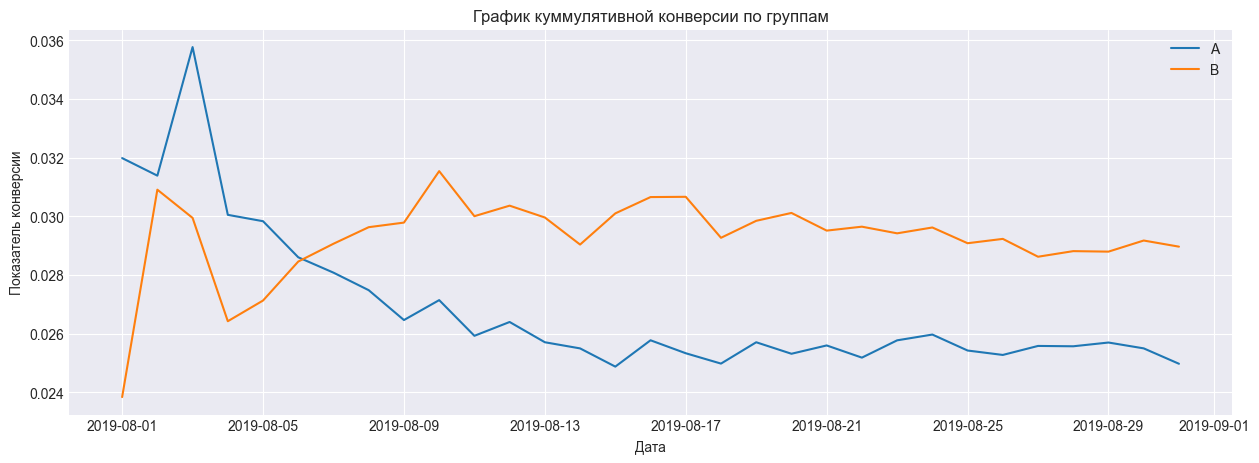

In [50]:
plt.figure(figsize=(15,5))
plt.plot(cummulative_conversion_a['date'], 
         cummulative_conversion_a['conversion'], 
         label='A')
plt.plot(cummulative_conversion_b['date'], 
         cummulative_conversion_b['conversion'], 
         label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Показатель конверсии')
plt.title('График куммулятивной конверсии по группам');

На графике видно, что конверсия по дням по группе А падала с начала теста и до 17.08., далее стабилизировалась на этом уровне.  

По группе Б изначально показатель был меньше, но спустя примерно неделю после начала теста конверсия увеличилась, и зафиксировалась выше, чем по группе А. 

Проверим это наблюдение на графике относительного изменения показателя группы Б к группе А. 

In [51]:
conversion_merged = cummulative_conversion_a.merge(cummulative_conversion_b, 
                                       left_on='date', 
                                       right_on = 'date',
                                       how = 'left',
                                       suffixes = ['A', 'B'])

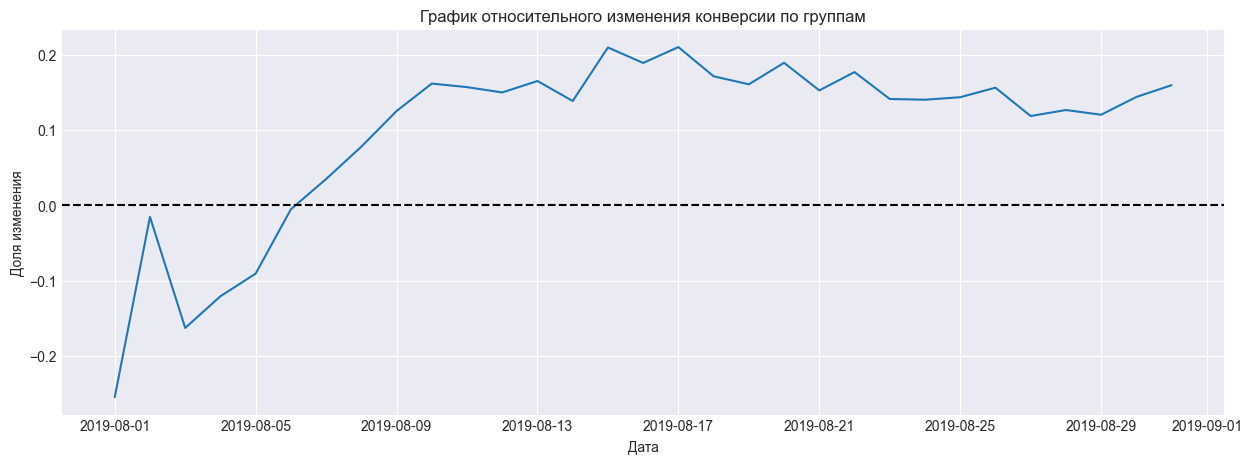

In [52]:
plt.figure(figsize=(15,5))
plt.plot(conversion_merged['date'], 
         (conversion_merged['conversionB']/conversion_merged['conversionA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Доля изменения')
plt.title('График относительного изменения конверсии по группам');

Догадка подтверждается. Куммулятивная конверсия по группе Б больше, чем по группе А. 

### Количество заказов на пользователя

Проверим, сколько заказов приходится на каждого пользователя. 

Для этого сгруппируем данные по `user_id` и построим визуализацию. 

In [53]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)

In [54]:
orders_by_users.columns = ['user_id', 'orders']

In [55]:
orders_by_users.sort_values('orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Видим, что наибольшее количество заказов среди наших пользователей
&#8212; 3. Проверим, как распределяются все значения. 

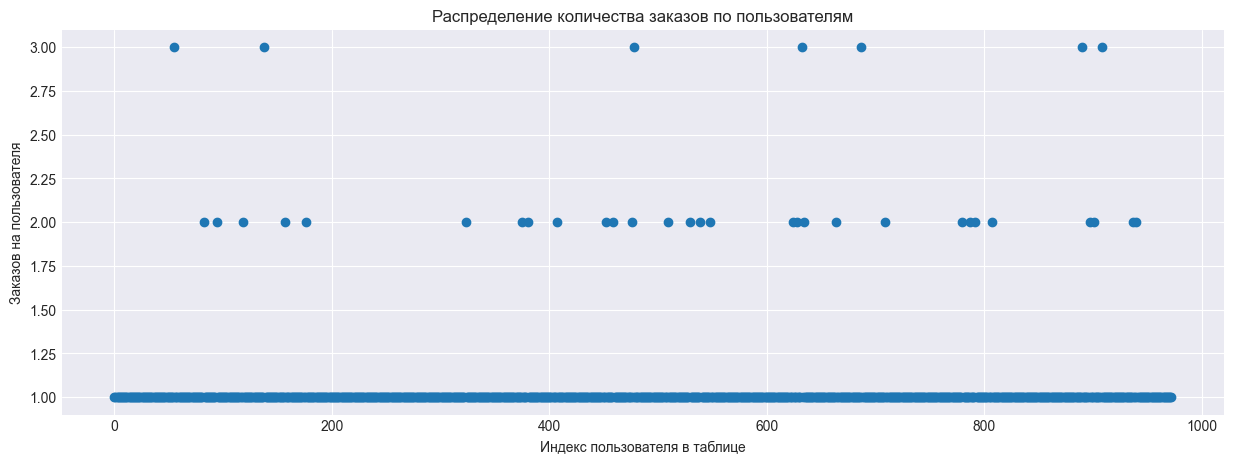

In [56]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel('Индекс пользователя в таблице')
plt.ylabel('Заказов на пользователя')
plt.title('Распределение количества заказов по пользователям');

График показывает, что наибольшее количество пользователей сделали 1 заказ. Редко кто сделал 2, и еще меньше 
&#8212; 3 заказа. 

Стоит проверить, как распределяются персентили по нашим значениям, и очистить данные от аномалий, чтобы соотнести результаты вывода по "чистым" данными с теми, которые были сделаны ранее. 

In [57]:
np.percentile(orders_by_users['orders'], [95, 99])

array([1., 2.])

Видим, что 99% клиентов сделали менее двух заказов. 

В дальнейшем анализе мы отсеим пользователей, у которых было более двух заказов, оставив  наиболее характерные значения в данных. Совсем убирать значения, отличные от 1, не стоит, так как проверив отличия по группам мы сможем понять, стало ли в какой-то из них больше повторных заказов. 

### Стоимость заказов по пользователям

Теперь проверим, как распределяется стоимость заказов по пользователям. Для этого также посмотроим точечную диаграмму. 

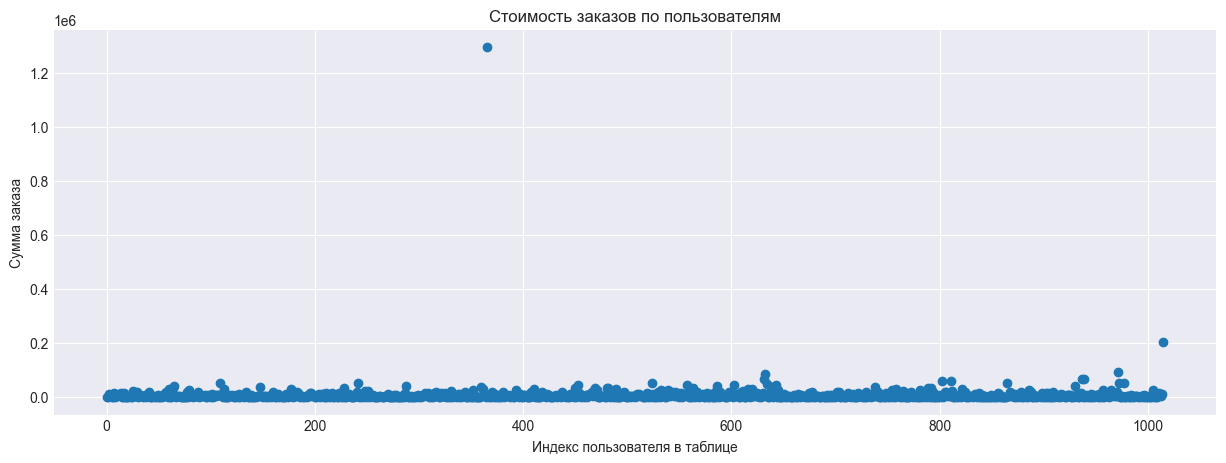

In [58]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Индекс пользователя в таблице')
plt.ylabel('Сумма заказа')
plt.title('Стоимость заказов по пользователям');

Такой график получается малоинформативным. Видим единичный выброс на сумму более 1.2 млн. Вероятно, он и был причиной резкого роста выручки и среднего чека по группе Б. Есть выброс в районе 300 тысяч. Остальные значения находятся существенно ниже. Ограничим значения по оси Y и построим график заново. 

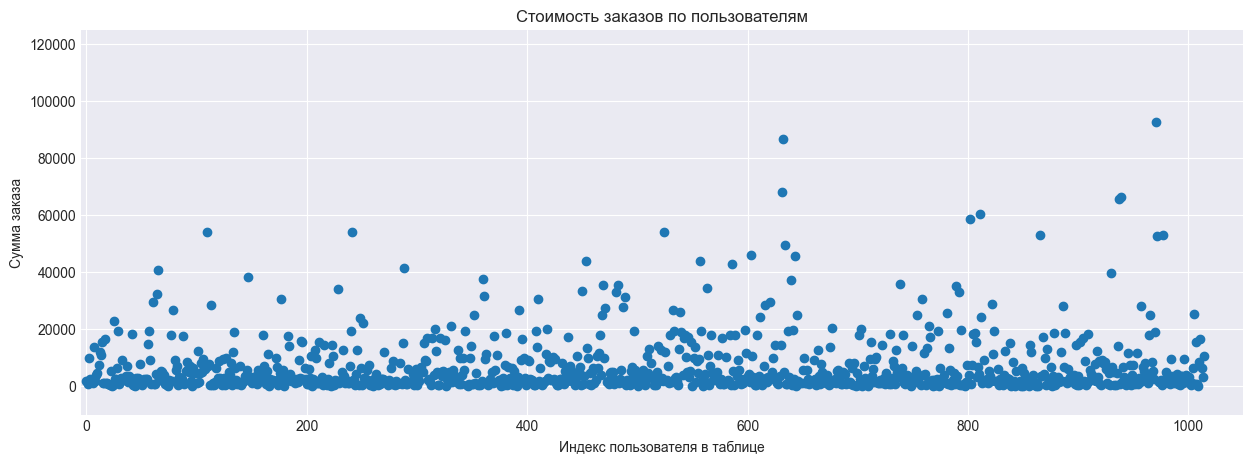

In [59]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue'])
plt.axis([-5, 1050, -10000, 125000])
plt.xlabel('Индекс пользователя в таблице')
plt.ylabel('Сумма заказа')
plt.title('Стоимость заказов по пользователям');

Теперь картина более ясная. Основная масса значений находится на уровне менее 10 000. До 20 000 их все еще много, и далее к 100 тысячам уже остаются крайне редкие значения.  

Найдем перцентили стоимости и определим, какие значения стоит оставить в "чистых данных". 

In [60]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

95 процентов заказв дешевле 28 000, 99 дешевле 58 тысяч.  

Оставим в наших данных только заказы стоимостью до 30 000. Остальные отсеим. 

## Проверка на статистическую значимость

Теперь время проверить, являются ли наблюдаемые нами различия между группами статистически значимыми. Также, влияет ли на это наличие аномалий в данных. 

### Среднее количество заказов

Для начала проверим разницу в среднем количестве заказов по исходным данным.  

Сначала сделаем выборки по группам пользователей. 

In [61]:
orders_by_user_a = orders[orders['group']=='A'][['transaction_id', 'visitor_id']]

In [62]:
orders_by_user_a = (
    orders_by_user_a.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
    )

In [63]:
orders_by_user_b = orders[orders['group']=='B'][['transaction_id', 'visitor_id']]

In [64]:
orders_by_user_b = (
    orders_by_user_b.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
    )

In [65]:
orders_by_user_a.head()

,visitor_id,transaction_id
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [66]:
orders_by_user_b.head()

,visitor_id,transaction_id
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Получили таблицы с количеством заказов по пользователям. Однако тут нет информации по пользователям, у которых не было заказов.  

Добавим нули по ним. 

In [67]:
sample_a = pd.concat(
    [
        orders_by_user_a['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                cummulative_data[cummulative_data['group']=='A']['visitors'].max() - 
                len(orders_by_user_a['transaction_id'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [68]:
sample_b = pd.concat(
    [
        orders_by_user_b['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                cummulative_data[cummulative_data['group']=='B']['visitors'].max() - 
                len(orders_by_user_b['transaction_id'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Данные подготовили.  

Теперь можем применить критерий Манна-Уитни и проверить, являются ли различия в среднем количестве заказов на пользователя по сырым данным статистически значимыми. 

Принимаем за альфа уровень значимости 5%
> **Ho**: среднее количество заказов по группам теста одинаковое;  
> **H1**: количество заказов на пользователя различается для исследуемых групп. 

In [69]:
print('p-value: ', "{0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительный прирост: ', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))


p-value:  0.011
Относительный прирост:  0.160


*p-value* получился 1,1%. Значит, разница в исходных данных является статистически значимой. Сама разница составляет 16%. 

Сразу проверим информацию по очищенным данным. Отфильтруем пользователей, которые сделали более двух заказов и у которых были заказы на сумму более 30 000.

In [70]:
users_with_many_orders = pd.concat(
    [
        orders_by_user_a[orders_by_user_a['transaction_id']>3]['visitor_id'],
        orders_by_user_b[orders_by_user_b['transaction_id']>3]['visitor_id']
     ],
     axis=0
)

In [71]:
users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

In [72]:
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [73]:
print(len(abnormal_users))
'{:.3f}'.format(len(abnormal_users)/orders['visitor_id'].nunique())

42


'0.043'

Получили выборку пользователей с аномальным поведением. Таких оказалось 42, 4.3% от всего числа пользователей. Теперь добавим два датасета по группам с отфильтрованными данными. 

In [74]:
sample_a_filtered = pd.concat(
    [
        orders_by_user_a[
            np.logical_not(orders_by_user_a['visitor_id'].isin(abnormal_users))
        ]['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                cummulative_data[cummulative_data['group']=='A']['visitors'].max() - 
                len(orders_by_user_a['transaction_id'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [75]:
sample_b_filtered = pd.concat(
    [
        orders_by_user_b[
            np.logical_not(orders_by_user_b['visitor_id'].isin(abnormal_users))
        ]['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                cummulative_data[cummulative_data['group']=='B']['visitors'].max() - 
                len(orders_by_user_b['transaction_id'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Проверяем статистическую значимость различий в отфильтрованных данных.  

In [76]:
print('p-value: ', "{0:.3f}".format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

print('Относительный прирост: ', "{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p-value:  0.013
Относительный прирост:  0.161


Ситуация не изменилась, результат остался статистически значимым.  

Относительное различие увеличилось на десятую долю процента. 

Можно сделать вывод, что среднее количество заказов в группе Б выросло относительно группы А. 

### Средний чек

Проверим статистическую значимость различий по среднему чеку для наших групп. Проведем подсчеты по исходным и отфильтрованным данным.  

Уровень значимости `alpha` 5%.

> **Ho**: средние чеки по группам не отличаются;  
> **H1**: средние чеки по группам имеют различия.

In [77]:
# на исходных данных
print(
    'p-value: ',
    '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                        orders[orders['group']=='B']['revenue'])[1])
)
print(
    'Относительный прирост: ', 
    '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                     orders[orders['group']=='A']['revenue'].mean()-1)
)

p-value:  0.829
Относительный прирост:  0.287


На "сырых" данных видим, что *p-value* существенно больше 5%, соответственно, изменения не являются статистически значимыми. Несмотря на то, что отличие на 29%, средний чек группы Б больше. 

In [78]:
# на отфильтрованных данных

print(
    'p-value: ',
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост: ', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value:  0.842
Относительный прирост:  -0.031


По отфильтрованным данным ситуация глобально не поменялась, *p-value* по-прежнему больше 5%, поэтому изменения не являются статистически значимыми.  

Однако разница между группами после фильтрации изменилась сильно, и теперь практически отсутствует, 3% против 29 на исходных данных. 

# Выводы

В ходе этого исследования работали с результатами A/B-теста новой опции.  

Мы оценили графики таких параметров как:  
> - куммулятивная выручка;  
> - куммулятивный средний чек;  
> - куммулятивное среднее кол-во заказов;  
> - количество и стоимость заказов на пользователя.  

Также проверили статистическую значимость в различиях таких показателей как средний чек покупки и среднее количество заказов на пользователя. 

В начале работы мы выявили наиболее приоритетную для проверки гипотезу.   

Это 7-я гипотеза, "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".  

Она охватывает наибольшее количество пользователей, а также имеет высокие оценки влияния на них и приемлемый уровень затрат на добавление самой опции.

**По итогам нашей проверки** можно сказать, что в тестируемой группе увеличилось количество заказов относительно контрольной на статистически значимую величину.  

Средний чек не имеет статистически значимых различий.  

Группы были проверены как на исходных данных, так и на очищенных от выбросов. 

Тест можно остановить. Полученных наблюдений достаточно, чтобы признать победу группы Б.  

Нововведение позволило увеличить количество заказов. При отсутствии разницы в среднем чеке это приводит к увеличению выручки. 